# GPU vs CPU Monte Carlo Demo (on Apple Silicon)

This notebook compares a simple Monte Carlo estimator implemented in two ways:

1. **CPU (NumPy, float64)** – baseline, traditional scientific computing.
2. **GPU (PyTorch on MPS, float32)** – uses the Apple Silicon GPU via the Metal backend.

We estimate
\begin{equation}
I_d = \mathbb{E}\left[ \frac{e^{-\tfrac12\lVert X \rVert^2}}{2^{-d/2}} \right], \quad X \sim \mathcal{N}(0, I_d),
\end{equation}
where the factor $2^{-d/2}$ is chosen so that
\begin{equation}
I_d \equiv 1 \quad \text{for all dimensions } d.
\end{equation}

Thus the **exact value is 1**, independent of `d`, which makes it easy to interpret absolute errors
as `|estimate − 1|`.

For each sample size `n` we run the experiment **multiple times** (`M` replications) and record only
the **empirical errors** (no standard errors or confidence intervals).


## 1. Imports and device check

You need **PyTorch** installed with Apple Silicon / MPS support. If `torch.backends.mps.is_available()`
is `False`, the GPU run will fall back to CPU so you will not see a real GPU speed-up.


In [1]:
import time
import platform
import subprocess

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


def _run_cmd(cmd):
    try:
        return subprocess.check_output(cmd, text=True)
    except Exception:
        return ""


def _get_mac_hardware_info():
    # Basic hardware (chip, cores, memory, model id)
    hw = _run_cmd(["system_profiler", "-detailLevel", "mini", "SPHardwareDataType"])

    info = {
        "chip": None,
        "cores": None,
        "memory": None,
        "model_id": None,
        "performance_cores": None,
        "efficiency_cores": None,
        "neural_engine_cores": None,
    }

    for line in hw.splitlines():
        line = line.strip()
        if line.startswith("Model Identifier:"):
            info["model_id"] = line.split(":", 1)[1].strip()
        elif line.startswith("Chip:") or line.startswith("Processor Name:"):
            info["chip"] = line.split(":", 1)[1].strip()
        elif line.startswith("Total Number of Cores:") or line.startswith("Number of Processors:"):
            info["cores"] = line.split(":", 1)[1].strip()
        elif line.startswith("Performance Cores:"):
            info["performance_cores"] = line.split(":", 1)[1].strip()
        elif line.startswith("Efficiency Cores:"):
            info["efficiency_cores"] = line.split(":", 1)[1].strip()
        elif line.startswith("Neural Engine Cores:"):
            info["neural_engine_cores"] = line.split(":", 1)[1].strip()
        elif line.startswith("Memory:"):
            info["memory"] = line.split(":", 1)[1].strip()

    # GPU info from Displays
    gpu_out = _run_cmd(["system_profiler", "-detailLevel", "mini", "SPDisplaysDataType"])
    gpus = []
    for line in gpu_out.splitlines():
        s = line.strip()
        if s.startswith("Chipset Model:") or s.startswith("Chipset:") or s.startswith("GPU:"):
            gpus.append(s.split(":", 1)[1].strip())

    info["gpus"] = gpus
    return info


def _memory_bandwidth_from_chip(chip: str | None) -> str | None:
    """
    Best-effort mapping from chip name to advertised unified memory bandwidth.
    Values are approximate and only filled in for common Apple Silicon chips.
    """
    if not chip:
        return None

    chip_lower = chip.lower()

    # Order matters: match more specific names first
    mapping = [
        ("m2 max", "400 GB/s"),
        ("m2 pro", "200 GB/s"),
        ("m2", "100 GB/s"),
        ("m1 max", "400 GB/s"),
        ("m1 pro", "200 GB/s"),
        ("m1", "68 GB/s"),
    ]

    for name, bw in mapping:
        if name in chip_lower:
            return bw

    return None


def _gpu_core_info_from_chip(chip: str | None) -> str | None:
    """
    Best-effort description of GPU core counts by chip family.
    We cannot see the exact config programmatically (e.g. 30 vs 38),
    so we report ranges where appropriate.
    """
    if not chip:
        return None

    s = chip.lower()
    if "m2 max" in s:
        return "30 or 38 GPU cores (depends on configuration; not distinguishable programmatically)"
    if "m2 pro" in s:
        return "16 or 19 GPU cores (varies by configuration)"
    if "m2" in s:
        return "up to 10 GPU cores (varies by configuration)"
    if "m1 max" in s:
        return "24 or 32 GPU cores (varies by configuration)"
    if "m1 pro" in s:
        return "14 or 16 GPU cores (varies by configuration)"
    if "m1" in s:
        return "7 or 8 GPU cores (varies by configuration)"
    return None


def _power_modes_from_pmset():
    """
    Inspect pmset to see Low Power / High Power modes where available.
    This is best-effort and may not report anything on some Macs.
    """
    out = _run_cmd(["pmset", "-g"])
    low_power = None
    high_power = None

    for line in out.splitlines():
        s = line.strip().lower()
        if s.startswith("lowpowermode"):
            try:
                low_power = int(s.split()[-1])
            except Exception:
                pass
        if "highpowermode" in s:
            try:
                high_power = int(s.split()[-1])
            except Exception:
                pass

    return low_power, high_power


def print_system_and_device_summary():
    # --- Python / library versions ---
    print("=== Python / Libraries ===")
    print(f"Python version : {platform.python_version()}")
    print(f"Platform       : {platform.platform()}")
    print(f"NumPy version  : {np.__version__}")
    try:
        print(f"PyTorch version: {torch.__version__}")
    except Exception:
        print("PyTorch version: <not available>")

    # --- Choose PyTorch device ---
    if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        device = torch.device("mps")
        backend_desc = "Apple Metal Performance Shaders (MPS, Apple GPU)"
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        backend_desc = "CUDA (discrete GPU)"
    else:
        device = torch.device("cpu")
        backend_desc = "CPU only (no GPU backend visible to PyTorch)"

    print(f"\nSelected device: {device}  [{backend_desc}]")

    # --- Mac hardware details ---
    info = _get_mac_hardware_info()

    print("\n=== Mac Hardware ===")
    if info["chip"]:
        print(f"Chip / CPU          : {info['chip']}")
    if info["cores"]:
        print(f"Total CPU cores     : {info['cores']}")
    if info["performance_cores"] or info["efficiency_cores"]:
        print(f"  - Performance cores: {info['performance_cores']}")
        print(f"  - Efficiency cores : {info['efficiency_cores']}")
    if info["memory"]:
        print(f"Unified memory      : {info['memory']}")
    if info["model_id"]:
        print(f"Model identifier    : {info['model_id']}")
    if info["neural_engine_cores"]:
        print(f"Neural Engine       : {info['neural_engine_cores']} cores")

    bw = _memory_bandwidth_from_chip(info["chip"])
    if bw:
        print(f"Memory bandwidth    : {bw} (from chip family, approximate)")
    else:
        print("Memory bandwidth    : not reliably detected from this system")

    gpu_core_info = _gpu_core_info_from_chip(info["chip"])
    if gpu_core_info:
        print(f"GPU core configuration: {gpu_core_info}")

    gpus = info.get("gpus") or []
    print(f"\nGPUs visible to macOS: {len(gpus)}")
    for g in gpus:
        print(f"  - {g}")

    # --- Power / performance mode (best effort) ---
    print("\n=== Power / Performance Mode (best-effort) ===")
    low_power, high_power = _power_modes_from_pmset()
    if low_power is not None:
        print(f"Low Power Mode      : {'ON' if low_power else 'OFF'}")
    else:
        print("Low Power Mode      : not reported by pmset")

    if high_power is not None:
        print(f"High Power Mode     : {'ON' if high_power else 'OFF'}")
    else:
        print("High Power Mode     : not reported (only on some models / OS versions)")

    return device


# ---- Run once at the top of the notebook ----
device = print_system_and_device_summary()

=== Python / Libraries ===
Python version : 3.12.11
Platform       : macOS-26.1-arm64-arm-64bit
NumPy version  : 2.3.2
PyTorch version: 2.8.0

Selected device: mps  [Apple Metal Performance Shaders (MPS, Apple GPU)]

=== Mac Hardware ===
Chip / CPU          : Apple M3 Max
Total CPU cores     : 16 (12 performance and 4 efficiency)
Unified memory      : 128 GB
Model identifier    : Mac15,8
Memory bandwidth    : not reliably detected from this system

GPUs visible to macOS: 1
  - Apple M3 Max

=== Power / Performance Mode (best-effort) ===
Low Power Mode      : not reported by pmset
High Power Mode     : not reported (only on some models / OS versions)


## 2. Monte Carlo estimators (rescaled so exact value is 1)

We implement the same Monte Carlo estimator three times:

- `mc_cpu_float64`: uses **NumPy** on CPU with `float64`.
- `mc_cpu_float32`: uses **NumPy** on CPU with `float32`.
- `mc_gpu_float32`: uses **PyTorch** on `device` (preferably MPS/GPU) with `float32`.

For each sample we compute
\begin{equation}
f(X) = \frac{e^{-\tfrac12\lVert X \rVert^2}}{2^{-d/2}},
\end{equation}
so that the exact expectation is 1 for all `d`.


In [2]:
def mc_cpu_float64(n: int, d: int) -> float:
    """Monte Carlo estimator on CPU using NumPy float64, rescaled so true value is 1."""
    # Normalization constant so that E[exp(-0.5||X||^2)/norm_const] = 1
    norm_const = (1 / np.sqrt(2.0)) ** d  # 2^(-d/2)
    x = np.random.normal(size=(n, d)).astype(np.float64)
    vals = np.exp(-0.5 * np.sum(x ** 2, axis=1)) / norm_const
    return float(vals.mean())

def mc_cpu_float32(n: int, d: int) -> float:
    """Monte Carlo estimator on CPU using NumPy float32, rescaled so true value is 1."""
    norm_const = (1 / np.sqrt(2.0)) ** d  # 2^(-d/2)
    x = np.random.normal(size=(n, d)).astype(np.float32)
    # Compute squared norms in float32
    sq = np.sum(x ** 2, axis=1, dtype=np.float32)
    vals = np.exp(-0.5 * sq).astype(np.float32) / np.float32(norm_const)
    return float(vals.mean(dtype=np.float32))

def mc_gpu_float32(n: int, d: int) -> float:
    """Monte Carlo estimator on GPU/CPU using PyTorch float32, rescaled so true value is 1.

    If `device` is "mps", this uses the Apple Silicon GPU via Metal.
    """
    norm_const = (1.0 / np.sqrt(2.0)) ** d
    norm_const_t = torch.tensor(norm_const, device=device, dtype=torch.float32)

    x = torch.randn((n, d), device=device, dtype=torch.float32)
    vals = torch.exp(-0.5 * torch.sum(x ** 2, dim=1)) / norm_const_t
    return float(vals.mean().item())


def time_run(func, *args, sync_gpu: bool = False, **kwargs):
    """Utility to time a function call and return (value, elapsed_seconds).

    If `sync_gpu` is True and the global `device` is a GPU backend (MPS or CUDA),
    we synchronize before and after the call so that the timing reflects the
    actual wall-clock time of the GPU work (PyTorch GPU ops are asynchronous).
    """
    dev_type = getattr(device, "type", "").lower()

    if sync_gpu and dev_type in ("mps", "cuda"):
        if dev_type == "mps":
            torch.mps.synchronize()
        elif dev_type == "cuda":
            torch.cuda.synchronize()

    t0 = time.perf_counter()
    val = func(*args, **kwargs)

    if sync_gpu and dev_type in ("mps", "cuda"):
        if dev_type == "mps":
            torch.mps.synchronize()
        elif dev_type == "cuda":
            torch.cuda.synchronize()

    t1 = time.perf_counter()
    return val, t1 - t0


### Timing GPU code: why do we call `synchronize`?

PyTorch operations on a GPU backend (either Apple’s MPS or NVIDIA CUDA) are **asynchronous**:
when you call a function like `mc_gpu_float32`, PyTorch *launches* work on the GPU and then
immediately returns control to Python, while the GPU is still crunching in the background.

If we simply did

```python
t0 = time.perf_counter()
val = mc_gpu_float32(...)
t1 = time.perf_counter()
```

then `t1 - t0` would mostly measure how fast we can *launch* kernels, not how long the GPU
actually spends doing the computation. The GPU would still be working after `t1`.

To get an honest wall‑clock timing for the GPU work, we need to force the CPU to **wait until
the GPU is finished** before we stop the timer. That is what the `synchronize` calls do:

- `torch.mps.synchronize()` for Apple Silicon (MPS backend)
- `torch.cuda.synchronize()` for CUDA GPUs

Our helper

```python
def time_run(func, *args, sync_gpu: bool = False, **kwargs):
    ...
```

uses these calls only when `sync_gpu=True` *and* the selected `device` is a real GPU backend
(`"mps"` or `"cuda"`). For pure CPU runs, `sync_gpu` is `False`, so there is no extra overhead.

In short:

- **CPU timing**: just start/end the timer.
- **GPU timing**: start timer → launch work → wait for GPU to finish → stop timer.

This ensures that the CPU vs GPU runtime comparison in the notebook is **fair and accurate**.

## 3. Parameters: dimension, sample sizes, and replications

- `d` – dimension of the normal vector.
- `ns` – list of sample sizes.
- `R` – number of **independent replications** per `(n, device)` combination.


In [3]:
d = 20                 # dimension of the normal vector
ns = [10_000, 100_000, 1_000_000]
R = 20                 # number of replications per n (change as desired)

exact_value = 1.0
print("Dimension d =", d)
print("Sample sizes n =", ns)
print("Number of replications R =", R)
print("Exact value (all d):", exact_value)


Dimension d = 20
Sample sizes n = [10000, 100000, 1000000]
Number of replications R = 20
Exact value (all d): 1.0


## 4. Run experiments with replications

For each `n` and each device (CPU / GPU) we perform `R` independent runs, and record:

- the estimate,
- the absolute error `|estimate − 1|`,
- the runtime.

We store all runs in a long-format DataFrame `df_runs`, and then compute summary statistics
by grouping over `(n, device)`.


In [4]:
records = []

for n in ns:
    for r in range(R):
        # CPU float64 run
        val_cpu64, t_cpu64 = time_run(mc_cpu_float64, n, d, sync_gpu=False)
        err_cpu64 = abs(val_cpu64 - exact_value)
        records.append(
            {
                "n": n,
                "rep": r,
                "device": "CPU64",
                "value": val_cpu64,
                "abs_error": err_cpu64,
                "time_s": t_cpu64,
            }
        )

        # CPU float32 run
        val_cpu32, t_cpu32 = time_run(mc_cpu_float32, n, d, sync_gpu=False)
        err_cpu32 = abs(val_cpu32 - exact_value)
        records.append(
            {
                "n": n,
                "rep": r,
                "device": "CPU32",
                "value": val_cpu32,
                "abs_error": err_cpu32,
                "time_s": t_cpu32,
            }
        )

        # GPU float32 run
        val_gpu32, t_gpu32 = time_run(mc_gpu_float32, n, d, sync_gpu=True)
        err_gpu32 = abs(val_gpu32 - exact_value)
        records.append(
            {
                "n": n,
                "rep": r,
                "device": "GPU32",
                "value": val_gpu32,
                "abs_error": err_gpu32,
                "time_s": t_gpu32,
            }
        )

df_runs = pd.DataFrame.from_records(records)
df_runs.head()


n  rep device     value  abs_error    time_s
0  10000    0  CPU64  1.002395   0.002395  0.004122
1  10000    0  CPU32  0.976310   0.023690  0.002834
2  10000    0  GPU32  1.051383   0.051383  0.103788
3  10000    1  CPU64  0.951541   0.048459  0.002753
4  10000    1  CPU32  0.982128   0.017872  0.002623

### Summary table over replications

We summarize by `(n, device)` to get:

- average absolute error across replications,
- median, minimum, and maximum absolute error,
- average runtime,
- an average speed-up factor (CPU mean time / GPU mean time) for each `n`.


In [5]:
summary = (
    df_runs
    .groupby(["n", "device"], as_index=False)
    .agg(
        mean_abs_error=("abs_error", "mean"),
        median_abs_error=("abs_error", "median"),
        min_abs_error=("abs_error", "min"),
        max_abs_error=("abs_error", "max"),
        mean_time_s=("time_s", "mean"),
    )
)

# Compute mean speed-up per n: CPU64_mean_time / GPU32_mean_time
speedup_records = []
for n in ns:
    row_cpu64 = summary[(summary["n"] == n) & (summary["device"] == "CPU64")]
    row_gpu32 = summary[(summary["n"] == n) & (summary["device"] == "GPU32")]
    if not row_cpu64.empty and not row_gpu32.empty:
        cpu_t = float(row_cpu64["mean_time_s"].iloc[0])
        gpu_t = float(row_gpu32["mean_time_s"].iloc[0])
        speedup = cpu_t / gpu_t if gpu_t > 0 else np.nan
        speedup_records.append({"n": n, "mean_speedup_CPU64_over_GPU32": speedup})

df_speedup = pd.DataFrame(speedup_records)
summary_merged = summary.merge(df_speedup, on="n", how="left")
summary_merged


n device  mean_abs_error  median_abs_error  min_abs_error  \
0    10000  CPU32        0.029434          0.020710       0.000932   
1    10000  CPU64        0.029120          0.026486       0.000072   
2    10000  GPU32        0.031492          0.024347       0.001921   
3   100000  CPU32        0.012667          0.010381       0.002474   
4   100000  CPU64        0.011430          0.007366       0.000171   
5   100000  GPU32        0.008315          0.006655       0.000104   
6  1000000  CPU32        0.003409          0.003138       0.000101   
7  1000000  CPU64        0.002474          0.001912       0.000083   
8  1000000  GPU32        0.003206          0.002626       0.000426   

   max_abs_error  mean_time_s  mean_speedup_CPU64_over_GPU32  
0       0.094809     0.002624                       0.445119  
1       0.068754     0.002787                       0.445119  
2       0.095352     0.006262                       0.445119  
3       0.031954     0.025600                      10.186124  
4       0.034898     0.024984                      10.186124  
5       0.027533     0.002453                      10.186124  
6       0.008830     0.257255                      43.401909  
7       0.006620     0.271156                      43.401909  
8       0.008018     0.006248                      43.401909

## 5. Runtime comparison (mean over replications)

We plot the **mean runtime** for CPU and GPU at each `n`.


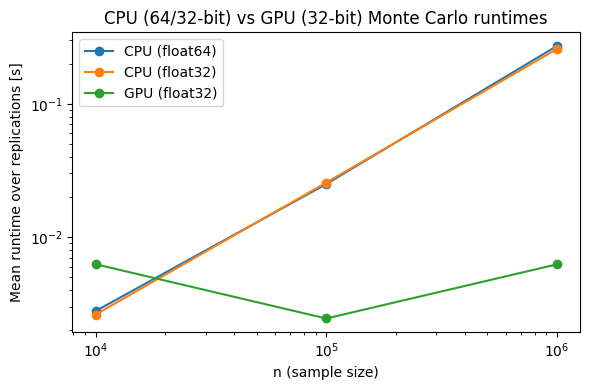

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

for device_name, label in [
    ("CPU64", "CPU (float64)"),
    ("CPU32", "CPU (float32)"),
    ("GPU32", "GPU (float32)"),
]:
    sub = summary[summary["device"] == device_name]
    ax.plot(sub["n"], sub["mean_time_s"], marker="o", label=label)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("n (sample size)")
ax.set_ylabel("Mean runtime over replications [s]")
ax.set_title("CPU (64/32-bit) vs GPU (32-bit) Monte Carlo runtimes")
ax.legend()
plt.tight_layout()
plt.show()


## 6. Error comparison (empirical errors only)

We now compare **absolute errors**. We do not compute standard errors or confidence
intervals; we only use empirical errors from the runs.

First we plot the **mean absolute error** over replications as a function of `n` for each device
on a log–log scale.


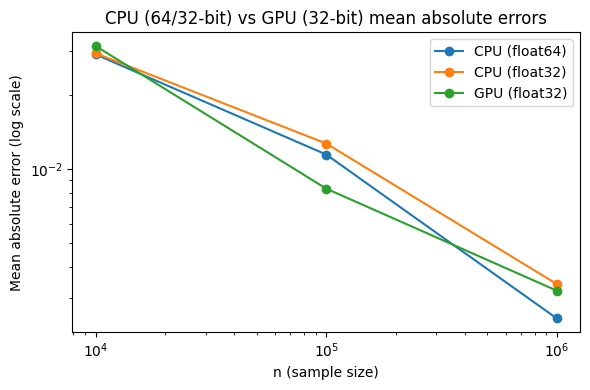

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))

for device_name, label in [
    ("CPU64", "CPU (float64)"),
    ("CPU32", "CPU (float32)"),
    ("GPU32", "GPU (float32)"),
]:
    sub = summary[summary["device"] == device_name]
    ax.plot(sub["n"], sub["mean_abs_error"], marker="o", label=label)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("n (sample size)")
ax.set_ylabel("Mean absolute error (log scale)")
ax.set_title("CPU (64/32-bit) vs GPU (32-bit) mean absolute errors")
ax.legend()
plt.tight_layout()
plt.show()


### Optional: scatter of individual absolute errors (log y-axis)

This plot shows all individual absolute errors for each `(n, device)` as jittered points on a
logarithmic vertical scale, to illustrate the spread of empirical errors across replications.


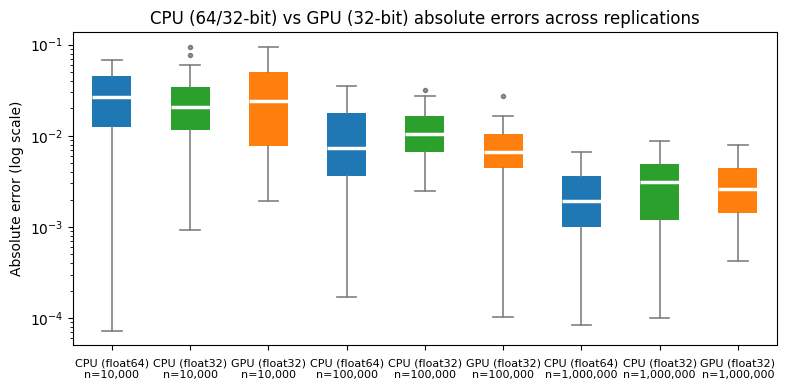

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))

# In df_runs we now have devices: "CPU64", "CPU32", "GPU32"
device_order = [
    ("CPU64", "CPU (float64)"),
    ("CPU32", "CPU (float32)"),
    ("GPU32", "GPU (float32)"),
]

boxdata = []
labels = []

for n in ns:
    for dev_key, dev_label in device_order:
        sub = df_runs[(df_runs["n"] == n) & (df_runs["device"] == dev_key)]
        if sub.empty:
            continue  # just in case
        boxdata.append(sub["abs_error"].to_numpy())
        labels.append(f"{dev_label}\nn={n:,}")

# Colors repeating in the same order: CPU64, CPU32, GPU32 for each n
base_colors = ["tab:blue", "tab:green", "tab:orange"]
colors = [base_colors[i % len(base_colors)] for i in range(len(boxdata))]

bp = ax.boxplot(
    boxdata,
    patch_artist=True,
    tick_labels=labels,
    medianprops=dict(color="white", linewidth=2.5),
    whiskerprops=dict(color="gray", linewidth=1.2),
    capprops=dict(color="gray", linewidth=1.2),
)

# Apply multiline tick labels with improved spacing
ax.set_xticklabels(labels, fontsize=8, rotation=0, ha="center")
ax.tick_params(axis='x', pad=6)

# Style boxes and medians
for patch, color in zip(bp["boxes"], colors):
    patch.set_edgecolor("none")
    patch.set_facecolor(color)

for median, color in zip(bp["medians"], colors):
    median.set_color("white")
    median.set_linewidth(2.5)

for flier in bp["fliers"]:
    flier.set_marker(".")
    flier.set_markersize(6)
    flier.set_markerfacecolor("black")
    flier.set_alpha(0.4)

ax.set_yscale("log")
ax.set_ylabel("Absolute error (log scale)")
ax.set_title("CPU (64/32-bit) vs GPU (32-bit) absolute errors across replications")

plt.tight_layout()
plt.show()

## 7. Discussion

- The integral was rescaled so that the exact value is **1**, making absolute error easy to interpret.
- For each `n`, we ran `R` independent replications for CPU and GPU and looked only at **empirical**
  errors `|estimate − 1|` (no standard errors or confidence intervals).
- On an Apple Silicon MacBook Pro with MPS enabled, you should see:
  - The GPU achieving noticeably smaller **mean runtime** for large `n`.
  - CPU and GPU **mean absolute errors** of similar magnitude for each `n`.
  - The error decreasing roughly like $n^{-1/2}$ on the log–log plot.
- Any unusually small error at a given `n` and device is usually due to **Monte Carlo luck**, not
  a fundamental accuracy difference between float32 and float64 for this smooth problem.


## 8. Many Expectations in Parallel (GPU-friendly batch example)

So far we estimated a **single expectation** on CPU vs GPU.
In many real applications we need the same kind of expectation for **many parameter values**.

Here we consider expectations of the form
\begin{equation}
I(a) = \mathbb{E}\left[ f_a(X) \right], \quad X \sim \mathcal{N}(0, I_d),
\end{equation}
where
\begin{equation}
f_a(X) = \frac{\exp\big(-\tfrac{1}{2}\lVert X - a \rVert^2\big)}{2^{-d/2}\,\exp(-\lVert a \rVert^2/4)}.
\end{equation}
One can show that this normalization makes
$$ I(a) = 1 \quad \text{for all } a \in \mathbb{R}^d. $$

We now choose **many centers** $a_1, \dots, a_M$ and estimate all $I(a_j)$ at once.
This is very natural for a GPU, which can process the resulting large tensor of
values in parallel.


### 8.1 Helper functions for many expectations

We implement CPU and GPU versions that, given:

- a sample size `n`,
- a dimension `d`,
- a matrix of centers `A` of shape `(M, d)`,

return **all** Monte Carlo estimates `[I(a_1), …, I(a_M)]`.


In [9]:
import numpy as np
import torch
import time

def mc_many_cpu_float64(n: int, d: int, A: np.ndarray) -> np.ndarray:
    """Compute M expectations on CPU using NumPy float64.

    A has shape (M, d). Returns an array of shape (M,) with one estimate per center.
    Each expectation is normalized so that the true value is 1 for all a.
    """
    A = np.asarray(A, dtype=np.float64)
    M_centers = A.shape[0]

    # Normalization constants: 2^(-d/2) * exp(-||a||^2 / 4) for each center a
    norm_const = (2.0 ** (-d / 2.0)) * np.exp(-0.25 * np.sum(A ** 2, axis=1))  # (M,)

    # Draw samples X ~ N(0, I_d)
    X = np.random.normal(size=(n, d)).astype(np.float64)  # (n, d)

    # Broadcast to (M, n, d): X_i - a_j
    diff = X[None, :, :] - A[:, None, :]  # (M, n, d)
    sqnorm = np.sum(diff ** 2, axis=-1)   # (M, n)
    vals = np.exp(-0.5 * sqnorm) / norm_const[:, None]

    return vals.mean(axis=1)  # (M,)


def mc_many_gpu_float32(n: int, d: int, A_torch: torch.Tensor, device: torch.device) -> torch.Tensor:
    """Compute M expectations on GPU/CPU using PyTorch float32.

    A_torch has shape (M, d) on the given device. Returns a tensor of shape (M,).
    Each expectation is normalized so that the true value is 1 for all a.
    """
    A_torch = A_torch.to(device=device, dtype=torch.float32)
    M_centers = A_torch.shape[0]

    # Normalization constants: 2^(-d/2) * exp(-||a||^2 / 4) for each center a
    norm_const = (2.0 ** (-d / 2.0)) * torch.exp(-0.25 * torch.sum(A_torch ** 2, dim=1))  # (M,)
    norm_const = norm_const.view(M_centers, 1)  # (M, 1) for broadcasting

    # Draw samples X ~ N(0, I_d) on the device
    X = torch.randn((n, d), device=device, dtype=torch.float32)  # (n, d)

    # Broadcast to (M, n, d): X_i - a_j
    diff = X.unsqueeze(0) - A_torch.unsqueeze(1)  # (M, n, d)
    sqnorm = torch.sum(diff ** 2, dim=-1)        # (M, n)
    vals = torch.exp(-0.5 * sqnorm) / norm_const

    return vals.mean(dim=1)  # (M,)



### 8.2 Timing many expectations: CPU vs GPU

We now fix a dimension `d` and a number of samples `n`, and increase the number of
centers `M`. The GPU will handle the batch `(M, n, d)` much more gracefully than
the CPU, especially as `M` becomes large.  In this case we only do `R=1` replication.

We also check that all estimated expectations stay close to 1, confirming that the
normalization is correct.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Dimension and sample size for this experiment
d_many = 20
n_many = 200_000

# Different numbers of centers M to try
Ms = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

# Generate a fixed bank of centers A_max, to be shared between CPU and GPU
M_max = max(Ms)
A_np = np.random.normal(size=(M_max, d_many))  # (M_max, d)

# Torch version of centers (we'll slice as needed)
A_torch = torch.from_numpy(A_np)

records_many = []

for M_centers in Ms:
    A_slice_np = A_np[:M_centers, :]
    A_slice_torch = A_torch[:M_centers, :]   # stay on CPU for now; function will move & cast

    # CPU timing
    est_cpu, t_cpu = time_run(mc_many_cpu_float64, n_many, d_many, A_slice_np, sync_gpu=False)
    # GPU timing
    est_gpu_t, t_gpu = time_run(mc_many_gpu_float32, n_many, d_many, A_slice_torch, device, sync_gpu=True)
    est_gpu = est_gpu_t.cpu().numpy()
    
    # Mean absolute error over the M centers (true value is 1 for each)
    cpu_mean_abs_err = float(np.mean(np.abs(est_cpu - 1.0)))
    gpu_mean_abs_err = float(np.mean(np.abs(est_gpu - 1.0)))

    records_many.append(
        {
            "M_centers": M_centers,
            "CPU time [s]": t_cpu,
            "GPU time [s]": t_gpu,
            "speedup (CPU/GPU)": t_cpu / t_gpu if t_gpu > 0 else np.nan,
            "CPU mean |error|": cpu_mean_abs_err,
            "GPU mean |error|": gpu_mean_abs_err,
        }
    )

df_many = pd.DataFrame.from_records(records_many)
df_many

M_centers  CPU time [s]  GPU time [s]  speedup (CPU/GPU)  CPU mean |error|  \
0          1      0.058398      0.018298           3.191502          0.020200   
1          5      0.090178      0.016155           5.582142          0.075446   
2         10      0.132716      0.019168           6.923806          0.023678   
3         20      0.233304      0.044261           5.271116          0.032698   
4         50      0.511696      0.067793           7.547926          0.041513   
5        100      0.980291      0.120583           8.129608          0.047760   
6        200      1.910606      0.230079           8.304123          0.048138   
7        500      6.121351      0.601076          10.183981          0.044871   
8       1000     29.179492      1.132716          25.760640          0.044149   

   GPU mean |error|  
0          0.014068  
1          0.049686  
2          0.027502  
3          0.038886  
4          0.033462  
5          0.048795  
6          0.040208  
7          0.044145  
8          0.042431

### 8.3 Plots for many expectations

We now visualize the runtime and the average absolute error for CPU and GPU as the
number of centers `M` increases.


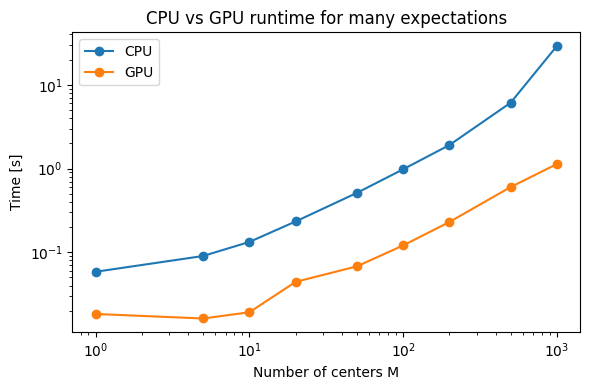

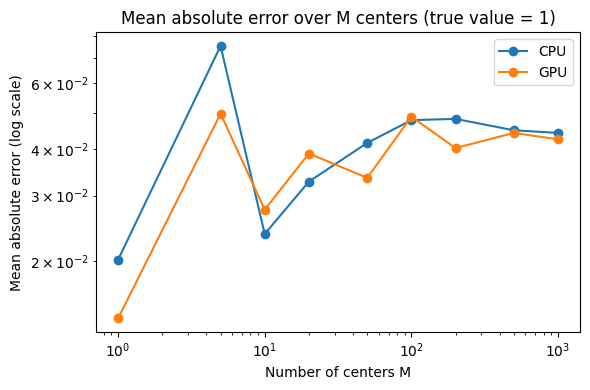

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df_many["M_centers"], df_many["CPU time [s]"], marker="o", label="CPU")
ax.plot(df_many["M_centers"], df_many["GPU time [s]"], marker="o", label="GPU")

ax.set_xlabel("Number of centers M")
ax.set_ylabel("Time [s]")
ax.set_title("CPU vs GPU runtime for many expectations")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df_many["M_centers"], df_many["CPU mean |error|"], marker="o", label="CPU")
ax.plot(df_many["M_centers"], df_many["GPU mean |error|"], marker="o", label="GPU")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of centers M")
ax.set_ylabel("Mean absolute error (log scale)")
ax.set_title("Mean absolute error over M centers (true value = 1)")
ax.legend()
plt.tight_layout()
plt.show()
